***Problem 1-Carseats Linear Regression***

**1(a) Fit a multiple linear regression model to predict Sales using Price, Urban, and US**

In [89]:
#데이터 관리 및 조작
import pandas as pd
df=pd.read_csv('/Users/lavi/MLDL_25_2_ASSIGNMENT/ASSIGNMENT_1/Data/Carseats.csv')

#Check Files for ensure
print(df.head())


   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  


In [90]:
#변수 설정
Y=df['Sales']
X=df[['Price', 'Urban','US']]

#Check data for ensure
print(Y.head())
print(X.head())

0     9.50
1    11.22
2    10.06
3     7.40
4     4.15
Name: Sales, dtype: float64
   Price Urban   US
0    120   Yes  Yes
1     83   Yes  Yes
2     80   Yes  Yes
3     97   Yes  Yes
4    128   Yes   No


In [91]:
# Quali. var.(Urban, US) 인코딩
X_encoded = pd.get_dummies(X, drop_first=True)
print(X_encoded.head())

   Price  Urban_Yes  US_Yes
0    120       True    True
1     83       True    True
2     80       True    True
3     97       True    True
4    128       True   False


In [92]:
# 머신러닝 (Using Scikit-Learn)
from sklearn.linear_model import LinearRegression

lin_model=LinearRegression(fit_intercept=True)
lin_model.fit(X_encoded,Y)

r2=lin_model.score(X_encoded,Y)

# Output Check
print("Intercept: ",lin_model.intercept_)
print("Parameters: ", lin_model.coef_)
print("R_square: ", r2)


Intercept:  13.043468936764892
Parameters:  [-0.05445885 -0.02191615  1.2005727 ]
R_square:  0.23927539218405547


*1(a),(b) Report by pdf file.*

*(a) Which contains the fitted coefficients (including the intercept) and the training R2 of the model.*

*(b) Write the fitted model in equation form, and Provide an interpretation of each coefficient in the model.*

**1(c) Closed-form OLS and comparison**

In [93]:
import numpy as np
n=len(X_encoded)
X_closed = np.column_stack((np.ones(n), X_encoded)).astype(float)

Y_closed=Y.values.reshape(-1,1)

#check dimension X:n*(p+1), y:(n*1)
print(X_closed.shape, Y_closed.shape)

(400, 4) (400, 1)


In [94]:
beta_hat=np.linalg.inv(X_closed.T @ X_closed) @ X_closed.T @ Y_closed

print(beta_hat)

[[13.04346894]
 [-0.05445885]
 [-0.02191615]
 [ 1.2005727 ]]


In [95]:
coef_sklearn = np.concatenate(([lin_model.intercept_], lin_model.coef_))

comparison = pd.DataFrame({
    'OLS_closed_form': beta_hat.flatten(),
    'sklearn': coef_sklearn,
})
comparison['abs_diff'] = abs(comparison['OLS_closed_form'] - comparison['sklearn'])
print(comparison)

   OLS_closed_form    sklearn      abs_diff
0        13.043469  13.043469  3.907985e-14
1        -0.054459  -0.054459  1.457168e-16
2        -0.021916  -0.021916  2.942091e-15
3         1.200573   1.200573  1.998401e-15


**1(d) test H0 : βj = 0 versus H1 : βj != 0 at level α = 0.05**

In [96]:
from scipy import stats

Y_hat=X_closed @ beta_hat
#sci-kit의 LinRegression으로 도출된 coef_sklearn과 closed form의 해석적 해 모두 사용하여도 된다.
# 두 값이 거의 동일하므로... 다만 coef_sklearn은 (4,)의 차원이므로 (4,1)의 차원으로 reshape(-1,1)필요함.
epsilon=Y_closed-Y_hat

n,p_plus_1=X_closed.shape
df=n-p_plus_1

sigma_sq=(epsilon.T @ epsilon)/df
sigma=np.sqrt(sigma_sq)

var=sigma_sq*np.linalg.inv(X_closed.T @ X_closed)
se=np.sqrt(np.diag(var))

t_stat=beta_hat.flatten()/se
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stat), df))


alpha = 0.05
significant = p_values < alpha

colnames = ['Intercept', 'Price', 'Urban_Yes', 'US_Yes']

t_table = pd.DataFrame({
    'Estimate': beta_hat.flatten(),
    'Std.Error': se,
    't value': t_stat,
    'Pr(>|t|)': p_values,
    'Significant (α=0.05)': significant
}, index=colnames)

print(t_table)

            Estimate  Std.Error    t value  Pr(>|t|)  Significant (α=0.05)
Intercept  13.043469   0.651012  20.035674  0.000000                  True
Price      -0.054459   0.005242 -10.389232  0.000000                  True
Urban_Yes  -0.021916   0.271650  -0.080678  0.935739                 False
US_Yes      1.200573   0.259042   4.634673  0.000005                  True


**1(e) Perform a validation set approach(7:3 random val & 5-fold cross val)**

In [97]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

random_seed = 1

X_train, X_val, y_train, y_val = train_test_split(
    X_encoded, Y, test_size=0.3, random_state=random_seed
)

#Check 7:3 sizing
print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}")

Train size: 280, Validation size: 120


*7:3 Validation*

In [98]:
lm = LinearRegression(fit_intercept=True)
lm.fit(X_train, y_train)

y_pred_val = lm.predict(X_val)

r2_val = r2_score(y_val, y_pred_val)
mse_val = mean_squared_error(y_val, y_pred_val)

print(f"Validation R²: {r2_val:.4f}")
print(f"Validation MSE: {mse_val:.4f}")


Validation R²: 0.2849
Validation MSE: 5.6138


*5-fold Cross Validation*

In [99]:
lm_cv = LinearRegression(fit_intercept=True)

r2_cv_scores = cross_val_score(lm_cv, X_encoded, Y, cv=5, scoring='r2')
mse_cv_scores = -cross_val_score(lm_cv, X_encoded, Y, cv=5, scoring='neg_mean_squared_error')

r2_cv_mean = np.mean(r2_cv_scores)
mse_cv_mean = np.mean(mse_cv_scores)

print(f"Cross-validated R² (mean): {r2_cv_mean:.4f}")
print(f"Cross-validated MSE (mean): {mse_cv_mean:.4f}")

Cross-validated R² (mean): 0.2038
Cross-validated MSE (mean): 6.1903


***Visualization***

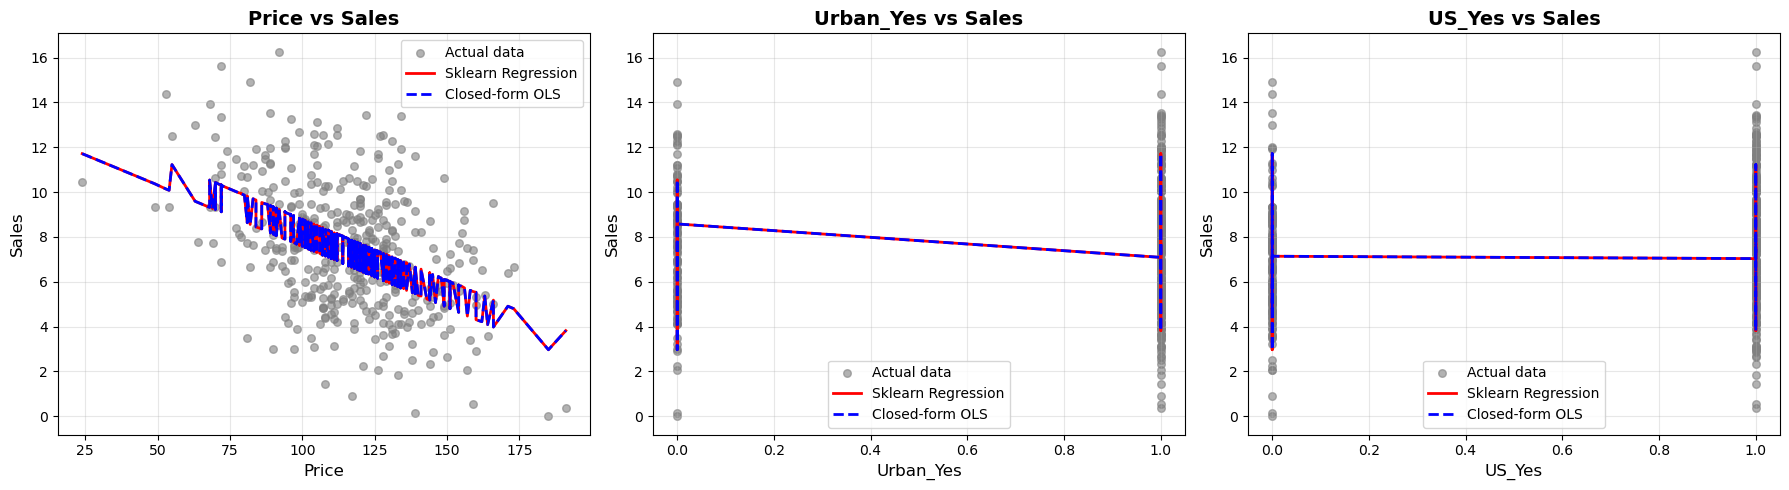

In [100]:
import matplotlib.pyplot as plt
import numpy as np


y_pred_sklearn = lin_model.predict(X_encoded)

y_pred_closed = X_closed @ beta_hat   # X_closed에는 intercept 포함되어 있어야 함


predictors = ['Price', 'Urban_Yes', 'US_Yes']
colors = {'data': 'gray', 'sklearn': 'red', 'ols': 'blue'}
linestyles = {'sklearn': '-', 'ols': '--'}
markersize = 30

fig, axes = plt.subplots(1, 3, figsize=(18, 5))


for i, col in enumerate(predictors):
    ax = axes[i]


    x = X_encoded[col].values
    y = Y.values


    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_pred_s_sorted = y_pred_sklearn[sort_idx]
    y_pred_c_sorted = y_pred_closed[sort_idx]


    ax.scatter(x, y, color=colors['data'], alpha=0.6, s=markersize, label='Actual data')


    ax.plot(x_sorted, y_pred_s_sorted, color=colors['sklearn'],
            linestyle=linestyles['sklearn'], linewidth=2, label='Sklearn Regression')


    ax.plot(x_sorted, y_pred_c_sorted, color=colors['ols'],
            linestyle=linestyles['ols'], linewidth=2, label='Closed-form OLS')


    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Sales', fontsize=12)
    ax.set_title(f'{col} vs Sales', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

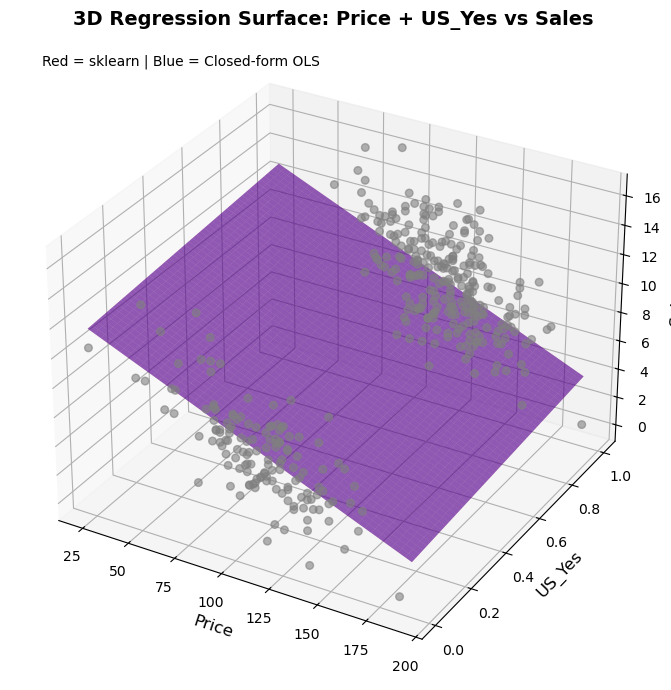

In [101]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# ----- 1️⃣ 두 feature와 target 선택 -----
x1 = X_encoded['Price'].values
x2 = X_encoded['US_Yes'].values
y = Y.values

# ----- 2️⃣ 두 모델 예측값 -----
y_pred_sklearn = lin_model.predict(X_encoded)
y_pred_closed = X_closed @ beta_hat

# ----- 3️⃣ 3D Figure 생성 -----
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# ----- 4️⃣ 실제 데이터 (회색 점) -----
ax.scatter(x1, x2, y, color='gray', alpha=0.6, s=30)

# ----- 5️⃣ 예측면(스무딩을 위해 grid 생성) -----
x1_range = np.linspace(min(x1), max(x1), 50)
x2_range = np.linspace(min(x2), max(x2), 50)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)

# sklearn 예측면
X_grid_sklearn = pd.DataFrame({
    'Price': x1_grid.ravel(),
    'Urban_Yes': np.mean(X_encoded['Urban_Yes']),  # 고정값 (평균 or 0)
    'US_Yes': x2_grid.ravel()
})
y_grid_sklearn = lin_model.predict(X_grid_sklearn).reshape(x1_grid.shape)

# closed-form 예측면
X_grid_closed = np.column_stack([
    np.ones(X_grid_sklearn.shape[0]),
    X_grid_sklearn.values
])
y_grid_closed = (X_grid_closed @ beta_hat).reshape(x1_grid.shape)

# ----- 6️⃣ 두 모델의 면을 각각 다른 색으로 -----
ax.plot_surface(x1_grid, x2_grid, y_grid_sklearn, color='red', alpha=0.4)
ax.plot_surface(x1_grid, x2_grid, y_grid_closed, color='blue', alpha=0.4)

# ----- 7️⃣ 축 이름 및 시각화 설정 -----
ax.set_xlabel('Price', fontsize=12)
ax.set_ylabel('US_Yes', fontsize=12)
ax.set_zlabel('Sales', fontsize=12)
ax.set_title('3D Regression Surface: Price + US_Yes vs Sales', fontsize=14, fontweight='bold')

# 범례 수동 추가
ax.text2D(0.05, 0.95, "Red = sklearn | Blue = Closed-form OLS", transform=ax.transAxes, fontsize=10, color='black')

plt.tight_layout()
plt.show()

***Problem 2(Logistic Regression)***

**2(a) LogisticRegression, fit a model to predict default from income and balance.**

In [102]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss

In [103]:
df = pd.read_csv("/Users/lavi/MLDL_25_2_ASSIGNMENT/ASSIGNMENT_1/Data/Default.csv")

print(df.head())

  default student      balance        income
0      No      No   729.526495  44361.625074
1      No     Yes   817.180407  12106.134700
2      No      No  1073.549164  31767.138947
3      No      No   529.250605  35704.493935
4      No      No   785.655883  38463.495879


In [104]:
df['default_bin'] = df['default'].map({'No': 0, 'Yes': 1})
X = df[['income', 'balance']]
y = df['default_bin']

In [105]:
RANDOM_SEED=1
np.random.seed(RANDOM_SEED)

In [106]:
pipe = Pipeline([
    ('scaler', StandardScaler()),  # 표준화 여부 O(StandardScaler)
    ('clf', LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=RANDOM_SEED))
])

In [107]:
pipe.fit(X, y)
clf = pipe.named_steps['clf']
intercept = clf.intercept_[0]
coef = clf.coef_[0]


In [108]:
p_train = pipe.predict_proba(X)[:, 1]

In [109]:
n = len(y)
train_loglik = -log_loss(y, p_train, normalize=False)

In [110]:
print(f"Standardization: Yes (StandardScaler used)")
print(f"Intercept: {intercept:.4f}")
print(f"Coefficients: Income={coef[0]:.6f}, Balance={coef[1]:.6f}")
print(f"Training Log-Likelihood: {train_loglik:.4f}")

Standardization: Yes (StandardScaler used)
Intercept: -6.1094
Coefficients: Income=0.279158, Balance=2.722327
Training Log-Likelihood: -789.4877


**2(b) Provide an interpretation of each coefficient on the log-odds scale & interpretation to the odds ratio scale via eβj**

In [111]:
beta_income = coef[0]
beta_balance = coef[1]

odds_income = np.exp(beta_income)
odds_balance = np.exp(beta_balance)

print(f"Income coefficient: {beta_income:.4f}, Odds Ratio = {odds_income:.3f}")
print(f"Balance coefficient: {beta_balance:.4f}, Odds Ratio = {odds_balance:.3f}")

Income coefficient: 0.2792, Odds Ratio = 1.322
Balance coefficient: 2.7223, Odds Ratio = 15.216


**2(c) Code the likelihood and optimize (no closed form)**

In [112]:
from scipy.optimize import minimize

In [113]:
df = pd.read_csv("/Users/lavi/MLDL_25_2_ASSIGNMENT/ASSIGNMENT_1/Data/Default.csv")
df['default_bin'] = df['default'].map({'No':0, 'Yes':1}).astype(int)
X = df[['income','balance']].copy()
y = df['default_bin'].values.astype(float)

In [114]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

In [115]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=RANDOM_SEED))
])
pipe.fit(X, y)
clf = pipe.named_steps['clf']

In [116]:
beta_std_sklearn = np.r_[clf.intercept_[0], clf.coef_[0]]
p_train = pipe.predict_proba(X)[:,1]
train_loglik_sklearn = -log_loss(y, p_train, normalize=False)

In [117]:
scaler = pipe.named_steps['scaler']
X_std = scaler.transform(X)
X_mat = np.column_stack([np.ones(len(X_std)), X_std]).astype(float)


In [118]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-np.clip(z, -35, 35)))

In [119]:
def neg_loglik(beta):
    z = X_mat @ beta
    p = sigmoid(z)
    eps = 1e-12
    return -np.sum(y*np.log(p + eps) + (1 - y)*np.log(1 - p + eps))

In [120]:
def grad_neg_loglik(beta):
    z = X_mat @ beta
    p = sigmoid(z)
    return X_mat.T @ (p - y)

In [121]:
beta0 = np.zeros(X_mat.shape[1])
res = minimize(neg_loglik, beta0, jac=grad_neg_loglik, method='BFGS', options={'gtol':1e-8, 'maxiter':1000})
beta_std_mle = res.x
max_loglik_mle = -res.fun

In [122]:
comp = pd.DataFrame({
    'param': ['Intercept','income(std)','balance(std)'],
    'sklearn(2a)': beta_std_sklearn,
    'MLE(c)': beta_std_mle,
    'abs_diff': np.abs(beta_std_sklearn - beta_std_mle)
})
print("=== (a) vs (c) coefficients on standardized scale ===")
print(comp)
print(f"\nTrain log-likelihood (sklearn 2a): {train_loglik_sklearn:.6f}")
print(f"Max log-likelihood (MLE 2c)      : {max_loglik_mle:.6f}")

=== (a) vs (c) coefficients on standardized scale ===
          param  sklearn(2a)    MLE(c)  abs_diff
0     Intercept    -6.109377 -6.125566  0.016190
1   income(std)     0.279158  0.277508  0.001651
2  balance(std)     2.722327  2.731452  0.009125

Train log-likelihood (sklearn 2a): -789.487744
Max log-likelihood (MLE 2c)      : -789.483135


In [123]:
mu = scaler.mean_
sigma = np.sqrt(scaler.var_)
beta0_std, beta_income_std, beta_balance_std = beta_std_mle

beta_income_raw  = beta_income_std  / sigma[0]
beta_balance_raw = beta_balance_std / sigma[1]
beta0_raw = beta0_std - (mu[0]/sigma[0])*beta_income_std - (mu[1]/sigma[1])*beta_balance_std

raw_params = pd.Series(
    [beta0_raw, beta_income_raw, beta_balance_raw],
    index=['Intercept(raw)','income(raw)','balance(raw)']
)
print("\n=== (optional) coefficients mapped back to original feature scale ===")
print(raw_params)


=== (optional) coefficients mapped back to original feature scale ===
Intercept(raw)   -11.540468
income(raw)        0.000021
balance(raw)       0.005647
dtype: float64


**2(d) Perform a validation set approach(7:3 random val & 5-fold cross val)**

In [124]:
from sklearn.metrics import accuracy_score

df = pd.read_csv("/Users/lavi/MLDL_25_2_ASSIGNMENT/ASSIGNMENT_1/Data/Default.csv")
df['default_bin'] = df['default'].map({'No':0, 'Yes':1}).astype(int)
X = df[['income','balance']]
y = df['default_bin']

RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

*7:3 random val*

In [125]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)

In [126]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=RANDOM_SEED))
])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(max_iter=1000, penalty=None,
                                    random_state=1))])

In [127]:
proba_val = pipe.predict_proba(X_val)[:, 1]
yhat_val = (proba_val >= 0.5).astype(int)
val_accuracy = accuracy_score(y_val, yhat_val)
val_misclass_rate = 1 - val_accuracy

print("=== Validation Set (70/30 split) ===")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Misclassification Rate: {val_misclass_rate:.4f}")


=== Validation Set (70/30 split) ===
Accuracy: 0.9760
Misclassification Rate: 0.0240


*5-fold Cross Validation*

In [128]:
cv_scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')
cv_misclass_rate = 1 - cv_scores.mean()

print("\n=== 5-Fold Cross Validation ===")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Mean Misclassification Rate: {cv_misclass_rate:.4f}")


=== 5-Fold Cross Validation ===
Mean Accuracy: 0.9735
Mean Misclassification Rate: 0.0265


**2(e) Include a dummy variable for student Using 5-fold cross-validation**

In [129]:
from sklearn.model_selection import cross_val_score

In [130]:
df['student_bin'] = df['student'].map({'No': 0, 'Yes': 1}).astype(int)

X2 = df[['income', 'balance', 'student_bin']]
y = df['default_bin']

In [131]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

In [132]:
pipe2 = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=RANDOM_SEED))
])

In [133]:
cv_scores_2e = cross_val_score(pipe2, X2, y, cv=5, scoring='accuracy')
cv_misclass_rate_2e = 1 - cv_scores_2e.mean()

print("=== (2e) Logistic Regression with student dummy ===")
print(f"Mean CV Accuracy: {cv_scores_2e.mean():.4f}")
print(f"Mean CV Misclassification Rate: {cv_misclass_rate_2e:.4f}")

=== (2e) Logistic Regression with student dummy ===
Mean CV Accuracy: 0.9732
Mean CV Misclassification Rate: 0.0268
